# Analysis of relative mRNA from Hippocampal Primary Neuron Cultures
Analysis by Tim Monko starting on March 17, 2023
The purpose of this analysis is to extend upon the previously conducted t-tests by Tommy et al. on 11, 18, and 21 DIV primary hippocampal neurons. 

### Experimental Model
1. Primary hippocampal cultures were harvested from E16.5 wildtype mouse brains. 
2. Cultures were initially placed in plating media (includes Glutamate), then after 4 hours transitioned to Glia Conditioned Neurobasal/B27 media
3. At 3DIV, media is replaced (Control condition / FeS, iron sufficient) and additionally dosed with the iron chelator DFO (DFO condition/ FeD, iron deficient)
4. At 14DIV, some DFO cultures were repleted with iron by removing DFO containing media (DFOR condition / FeR, FeD + iron repletion)

### Data acquired via qPCR
1. qPCR performed at 11, 18, or 21 DIV -- approximately corresponding to 1) the beginning of peak dendritic growth and synapse formation, 2) the end, or 3) mature neurons, respectively.
2. 

### Gene Info
Genes can be roughly grouped by their primary function in the following 3 ways:

**Neurodevelopment**

1. Nrgn (Neurogranin): glutamatergic pyramidal neurons, a Ca2+/calmodulin binding protein involved in synapses and associated with diseases with synaptic dysfunction
2. Pvalb (Parvalbumin): GABAergic inhibitory interneurons (fast-spiking, basket, axo-axonic and bistratified cells in HPC), a calcium signaling protein
3. Klf9 (KLF Tf 9/ Kruppel Like Factor 9): neuronal cell differentiation, KLF9 expression increases over time, especially throughout early and mid postnatal development, peaking at P30. *responsive to T3* https://pubmed.ncbi.nlm.nih.gov/19359381/ 
4. Hr: Neuronal metabolism

**TH related**

1. Crym (mu-crystallin homolog / NADP-regulated thyroid-hormone-binding-protein / THBP): TH binding protein
2. Dio2 (type II iodothyronine deiodinase): activates TH by converting T4 to bioactive T3
3. Hr (Hairless): transcriptional co-repressor for TH, interacts with HDACs
4. Slc16a2 (solute carrier family 16 member 2): TH transporter
5. Slco1c1 (solute carrier organic anion transporter family member 1C1): T4 transporter

**Iron related**

1. Tfr1 (transferrin receptor 1): binds extracellular Transferrin, thus importing iron via endocytosis. Upregulated if low labile iron (via disinhibition of IRP1/2) jelolo bvcVCXVXZ                                         


### Import libraries

In [36]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import os
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# for saving plots with svg, this saves text as text instead of ['paths']
sns.set_theme()
plt.rcParams['svg.fonttype'] = 'none'


## Open File
* Get file from online dataset using pandas and the sheet url

In [37]:
sheet_url = 'https://docs.google.com/spreadsheets/d/19h-r3Yt_8hF7_XPX3eaNRKUd1TwLMINUvsafSTVhLV0/edit#gid=0'
sheet_name = 'Sheet1'

sheet_id = (
    sheet_url
    .replace('/d/', '*')
    .replace('/edit', '*')
    .split('*')
)

url = f'https://docs.google.com/spreadsheets/d/{sheet_id[1]}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

raw_data = pd.read_csv(url)

# Convert indexing columns to appropriate data types. With sample as str because it is not useful as an int
raw_data['div'] = raw_data['div'].astype('str')
raw_data['tx'] = raw_data['tx'].astype('str')
raw_data['sample'] = raw_data['sample'].astype('str')
raw_data = raw_data.replace({'ctl': 'FeS', 'dfo': 'FeD', 'dfor': 'FeR'})

raw_data.head()


,div,tx,sample,Tfr1,Slc16a2,Slco1c1,Dio2,Crym,Hr,Klf9,Nrgn,Pvalb
0,11,FeS,1,0.887615,1.014553,NaN,0.735769,1.214971,0.867883,0.910328,0.857594,1.088394
1,11,FeS,5,1.019602,0.868310,NaN,1.077228,0.812623,0.760791,0.968926,1.034093,0.900615
2,11,FeS,9,1.092783,1.117137,NaN,1.187003,0.972406,1.371326,1.120746,1.108313,1.010990
3,11,FeS,59,0.986020,0.853487,0.831944,0.958570,1.195966,0.949874,0.954004,1.024060,0.912644
4,11,FeS,60,0.901056,1.093988,NaN,0.913170,1.031685,1.169432,1.073310,0.996057,1.026778


## Tidy the `raw_data`, convert to long form `data`
* Declare indexing columns to appropriate data types, isntead of pandas default
* Melt `raw_data` to long form `data` by using genes as variables. Set a multi-index.
* Create the `indexing` function to easily parse the multi-index data in different ways.

In [38]:
# Tidy data
data = (raw_data
        .melt(id_vars=['div', 'tx', 'sample'],
              var_name='gene',
              value_name='mrna'
              )

        )

data['gene'] = (
    data['gene']
    .astype('category')
    .cat.reorder_categories(['Tfr1', 'Slc16a2', 'Slco1c1', 'Dio2', 'Crym', 'Hr', 'Klf9', 'Nrgn', 'Pvalb'])
)

data['tx'] = (
    data['tx']
    .astype('category')
    .cat.reorder_categories(['FeS', 'FeD', 'FeR'])
)

data = data.sort_values(by=['gene', 'tx'])

data = data.set_index(['div', 'tx', 'sample', 'gene'])

data


mrna
div tx  sample gene           
11  FeS 1      Tfr1   0.887615
        5      Tfr1   1.019602
        9      Tfr1   1.092783
        59     Tfr1   0.986020
        60     Tfr1   0.901056
...                        ...
21  FeR 129    Pvalb  1.104688
        130    Pvalb  1.118760
        28     Pvalb       NaN
        29     Pvalb       NaN
        30     Pvalb       NaN

[918 rows x 1 columns]

#### Indexing function
Create indexing function to select specific data from the dataframe, such as by DIV or treatment

In [39]:
# Place here to update indexing arguments relative to index set above
def indexing(
        data=data,
        div=slice(None),
        tx=slice(None),
        sample=slice(None),
        gene=slice(None)
):
    """Parse multi-indexed pandas dataframe
    Not passing an argument is equivalent to selecting with : by using slice(None)
    Passing a list (even for a list of length 1) will keep the index, so this is encouraged. 
    Passing a string will drop the index column, but select it.
    """
    idx = pd.IndexSlice[div, tx, sample, gene]
    return data.loc[idx]


## Descriptive Statistics grouped by DIV, Tx, and gene
Uses the custom `indexing` function to tidy the dataset and then publish a small descriptive table. 

Not particularly useful to use these descriptive statistics most of the time, but provides a unique perspective if needed. 

In [34]:
desc_data = indexing(
    data=data,
    div=slice(None),
    tx=slice(None),
    sample=slice(None),
    gene=['Tfr1']
)

(desc_data
 .groupby(['gene', 'div', 'tx'])
 .describe()
 )


mrna                                                    \
             count      mean       std       min       25%       50%   
gene div tx                                                            
Tfr1 11  FeS  12.0  1.000000  0.058579  0.887615  0.985671  1.008051   
         FeD  12.0  1.745206  0.496947  1.354731  1.427663  1.577541   
     18  FeS  13.0  1.000000  0.066228  0.897171  0.950762  0.986297   
         FeD  13.0  2.379974  0.423480  1.583871  2.375793  2.459576   
     21  FeS  20.0  1.000000  0.205056  0.627014  0.927915  0.977124   
         FeD  16.0  1.944312  0.778389  1.131943  1.374130  1.489329   
         FeR  15.0  1.055788  0.224570  0.705207  0.892164  1.026787   

                                  
                   75%       max  
gene div tx                       
Tfr1 11  FeS  1.023462  1.092783  
         FeD  1.882112  3.137660  
     18  FeS  1.045275  1.123819  
         FeD  2.689531  2.829218  
     21  FeS  1.040953  1.485813  
         FeD  2.492311  3.238250  
         FeR  1.205021  1.512223

# Statistics with Pingouin

Use multi-ttesting. 

### 11DIV

In [10]:
stats_data = indexing(
    data=data.dropna().apply(np.log10),
    div=['11'],
).reset_index()

pwt = pg.pairwise_tests(
    data=stats_data,
    dv='mrna',
    between=['gene', 'tx'],
    nan_policy='pairwise',
).round(3)

pwt[pwt.gene != '-']


c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\pingouin\pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


,Contrast,gene,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
37,gene * tx,Tfr1,FeS,FeD,False,True,-7.393,22.000,two-sided,0.000,4.524e+04,-2.914
38,gene * tx,Slc16a2,FeS,FeD,False,True,0.661,15.790,two-sided,0.518,0.444,0.272
39,gene * tx,Slco1c1,FeS,FeD,False,True,-0.192,10.089,two-sided,0.852,0.429,-0.096
40,gene * tx,Dio2,FeS,FeD,False,True,0.075,22.000,two-sided,0.941,0.374,0.029
41,gene * tx,Crym,FeS,FeD,False,True,4.806,22.000,two-sided,0.000,234.722,1.894
42,gene * tx,Hr,FeS,FeD,False,True,2.749,22.000,two-sided,0.012,4.586,1.084
43,gene * tx,Klf9,FeS,FeD,False,True,5.456,22.000,two-sided,0.000,900.632,2.151
44,gene * tx,Nrgn,FeS,FeD,False,True,6.214,22.000,two-sided,0.000,4284.636,2.449
45,gene * tx,Pvalb,FeS,FeD,False,True,4.669,22.000,two-sided,0.000,177.243,1.841


### 18DIV

In [11]:
stats_data = indexing(
    data=data.dropna().apply(np.log10),
    div=['18'],
).reset_index()

pwt = pg.pairwise_tests(
    data=stats_data,
    dv='mrna',
    between=['gene', 'tx'],
    nan_policy='pairwise',
).round(3)

pwt[pwt.gene != '-']


c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\pingouin\pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


,Contrast,gene,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
37,gene * tx,Tfr1,FeS,FeD,False,True,-14.830,24.000,two-sided,0.000,2.641e+10,-5.633
38,gene * tx,Slc16a2,FeS,FeD,False,True,-4.884,16.794,two-sided,0.000,147.579,-2.143
39,gene * tx,Slco1c1,FeS,FeD,False,True,-2.624,15.133,two-sided,0.019,3.448,-1.123
40,gene * tx,Dio2,FeS,FeD,False,True,-6.038,24.000,two-sided,0.000,4187.839,-2.293
41,gene * tx,Crym,FeS,FeD,False,True,9.094,9.964,two-sided,0.000,1.306e+05,3.795
42,gene * tx,Hr,FeS,FeD,False,True,-2.651,24.000,two-sided,0.014,4.005,-1.007
43,gene * tx,Klf9,FeS,FeD,False,True,-0.866,24.000,two-sided,0.395,0.478,-0.329
44,gene * tx,Nrgn,FeS,FeD,False,True,2.321,24.000,two-sided,0.029,2.372,0.882
45,gene * tx,Pvalb,FeS,FeD,False,True,6.765,24.000,two-sided,0.000,2.008e+04,2.569


### 21 DIV 
multi anova version

In [12]:
anova_results = []
tukey_results = []

for gene in indexing(data=data.dropna(), div=['21']).reset_index().gene.unique():
    stats_data = indexing(
        data=data.dropna().apply(np.log10),
        div=['21'],
        gene=gene,
    ).reset_index()

    anova = pg.anova(
        data=stats_data,
        dv='mrna',
        between='tx'
    ).round(3)
    anova['gene'] = gene
    anova_results.append(anova)

    pwt = pg.pairwise_tukey(
        data=stats_data,
        dv='mrna',
        between='tx',
    ).round(3)
    pwt['gene'] = gene
    tukey_results.append(pwt)


In [15]:
# more efficient to concatenate the lists after the iterator
pd.concat(anova_results, ignore_index=True)


,Source,ddof1,ddof2,F,p-unc,np2,gene
0,tx,2,48,26.005,0.000,0.520,Tfr1
1,tx,2,36,7.742,0.002,0.301,Slc16a2
2,tx,2,39,3.353,0.045,0.147,Dio2
3,tx,2,40,109.205,0.000,0.845,Crym
4,tx,2,45,4.689,0.014,0.172,Hr
5,tx,2,21,3.007,0.071,0.223,Klf9
6,tx,2,23,6.441,0.006,0.359,Nrgn
7,tx,2,40,7.902,0.001,0.283,Pvalb


In [16]:
# more efficient to concatenate the lists after the iterator
pd.concat(tukey_results, ignore_index=True)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,gene
0,FeS,FeD,-0.009,0.258,-0.267,0.040,-6.717,0.000,-2.041,Tfr1
1,FeS,FeR,-0.009,0.015,-0.023,0.040,-0.570,0.837,-0.251,Tfr1
2,FeD,FeR,0.258,0.015,0.244,0.043,5.727,0.000,1.765,Tfr1
3,FeS,FeD,-0.010,0.079,-0.089,0.034,-2.647,0.031,-0.921,Slc16a2
4,FeS,FeR,-0.010,0.129,-0.139,0.037,-3.778,0.002,-1.457,Slc16a2
5,FeD,FeR,0.079,0.129,-0.051,0.037,-1.350,0.378,-0.583,Slc16a2
6,FeS,FeD,-0.012,0.152,-0.164,0.068,-2.414,0.053,-1.194,Dio2
7,FeS,FeR,-0.012,0.124,-0.136,0.073,-1.867,0.162,-0.658,Dio2
8,FeD,FeR,0.152,0.124,0.028,0.076,0.370,0.928,0.119,Dio2
9,FeS,FeD,-0.004,-0.455,0.451,0.031,14.683,0.000,5.465,Crym


# Plotting with Seaborn Objects

## Univariate Objects Plots
Currently plotting with seaborn objects has some limitations. But as it improves in the future, I suspect easy to understand and beautiful plots will be easier to create

This block defines the `univariate_plot` function

In [46]:
# Univariate Plot Function
def univariate_plot(
    folder_name='test_folder',
    file_name='test.svg',
    tick_list=[0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 3, 4],
    plot_data=indexing(
        data=data.dropna(),
        div=['11', '18', '21'],
        gene=['Tfr1'],
    ).reset_index(),
    x_label='',
    y_label='Relative mRNA level',
    title_label=None,
    y_share=False,
    facet_col='gene',
    layout_size=(3, 3)
):
    # Create save location, as necessary
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    save_loc = pathlib.Path(folder_name + '/' + file_name)

    plot_data['gene'] = plot_data.gene.astype('str')
    plot_data['tx'] = plot_data.tx.astype('str')

    p = (
        so.Plot(
            data=plot_data,
            y='mrna',
            x='tx',
            color='tx',
            marker='tx',
        )
        .facet(col=facet_col)
        .share(x=False, y=y_share)
        .add(so.Dots(alpha=0.6), so.Jitter(0.2), so.Shift(x=0.1))
        .add(so.Dot(), so.Agg(), so.Shift(x=-0.1))
        .add(so.Range(), so.Est(errorbar='sd'), so.Shift(x=-0.1))
        .label(
            x=x_label,
            y=y_label,
            title=title_label,
        )
        .layout(size=layout_size)
        .scale(
            y=so.Continuous(trans='log').tick(
                at=tick_list).label(base=None, like='.1f'),
            color='colorblind',
            marker=so.Nominal(['o', '^', 's']),
        )
        .theme({
            'ytick.left': True,
            'ytick.color': '.5',
            'ytick.labelcolor': '.15',
            'axes.grid': True,
            'grid.alpha': 0.8,
        })
        .save(loc=save_loc, bbox_inches='tight')
    )
    return p


### TFR1 all DIVs

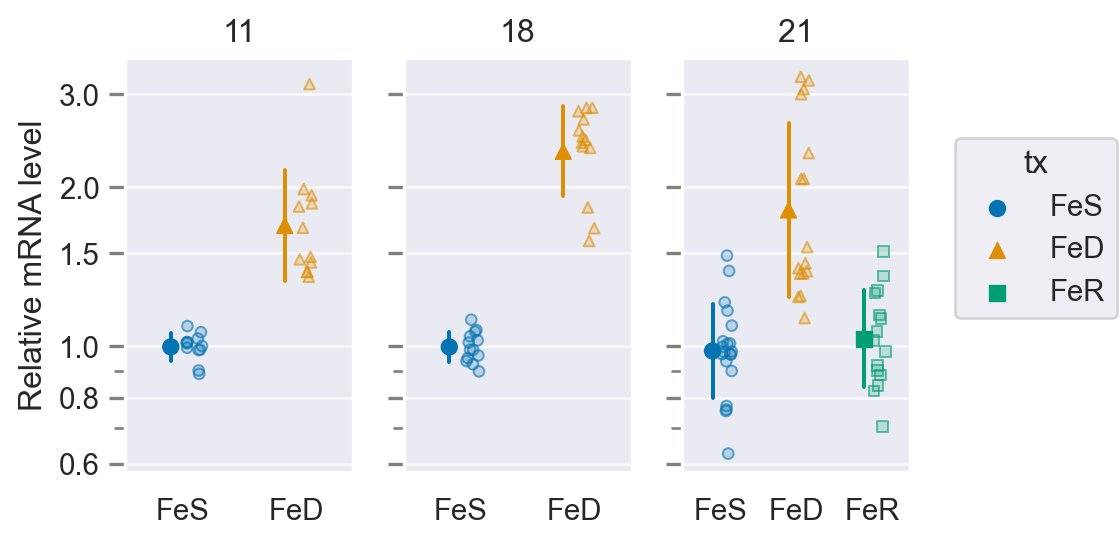

In [68]:
univariate_plot(
    folder_name='qPCR_univariate_fun',
    file_name='Tfr1-allDIV.svg',
    tick_list=[0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 3, 4],
    plot_data=indexing(
        data=data.dropna(),
        div=['11', '18', '21'],
        gene=['Tfr1'],
    ).reset_index(),
    x_label='',
    y_label='Relative mRNA level',
    title_label=None,
    y_share=True,
    facet_col='div',
    layout_size=(5, 3)
)


### 11DIV all genes (-Tfr1)

c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWa

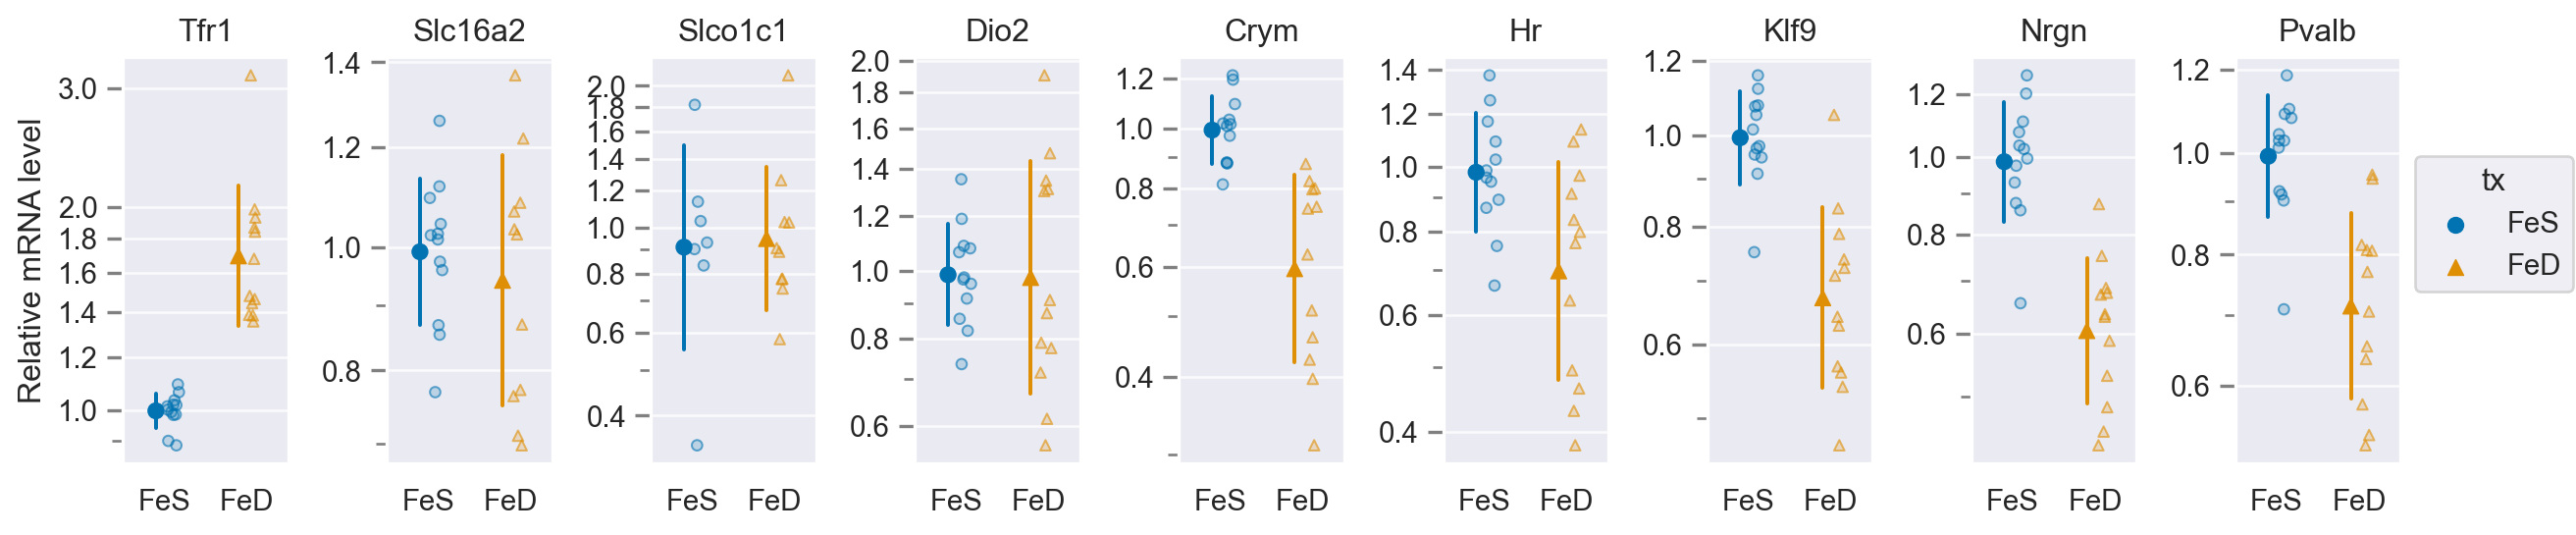

In [47]:
univariate_plot(
    folder_name='qPCR_univariate_fun',
    file_name='11DIV.svg',
    tick_list=[0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 3],
    plot_data=indexing(
        data=data.dropna(),
        div=['11'],
    ).reset_index(),
    x_label='',
    y_label='Relative mRNA level',
    y_share=False,
    facet_col='gene',
    layout_size=(15, 3)
)


### 18DIV all genes (-TFR1)

c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWarning: The marker list has more values (3) than needed (2), which may not be intended.
  warnings.warn(message, UserWarning)
c:\Users\timmo\mambaforge\envs\bastian-lab\lib\site-packages\seaborn\_core\properties.py:135: UserWa

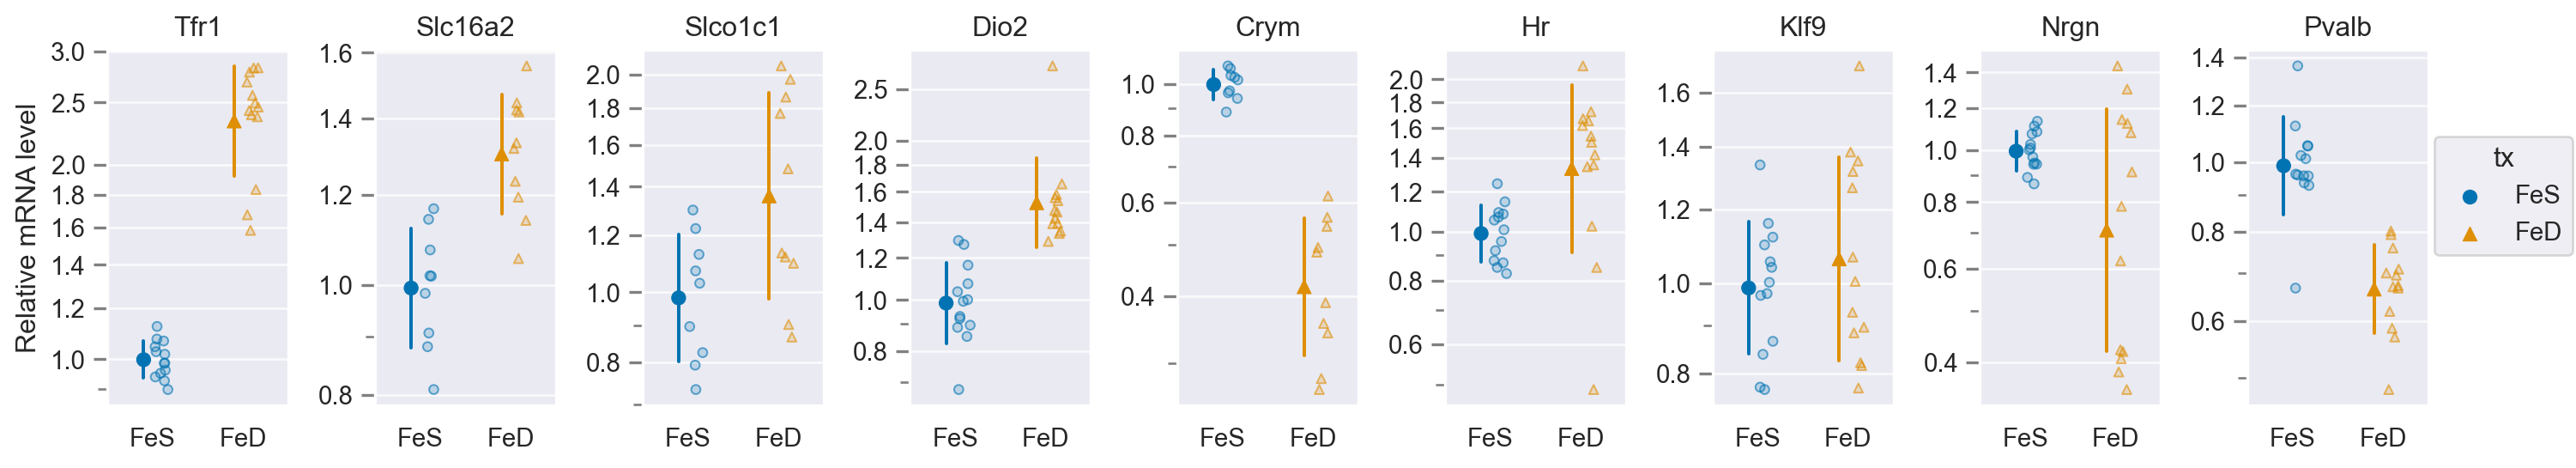

In [14]:
univariate_plot(
    folder_name='qPCR_univariate_fun',
    file_name='18DIV.svg',
    tick_list=[0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3],
    plot_data=indexing(
        data=data.dropna(),
        div=['18'],
    ).reset_index(),
    x_label='',
    y_label='Relative mRNA level',
    y_share=False,
    facet_col='gene',
    layout_size=(15, 3)
)


### 21DIV all genes (-Tfr1)

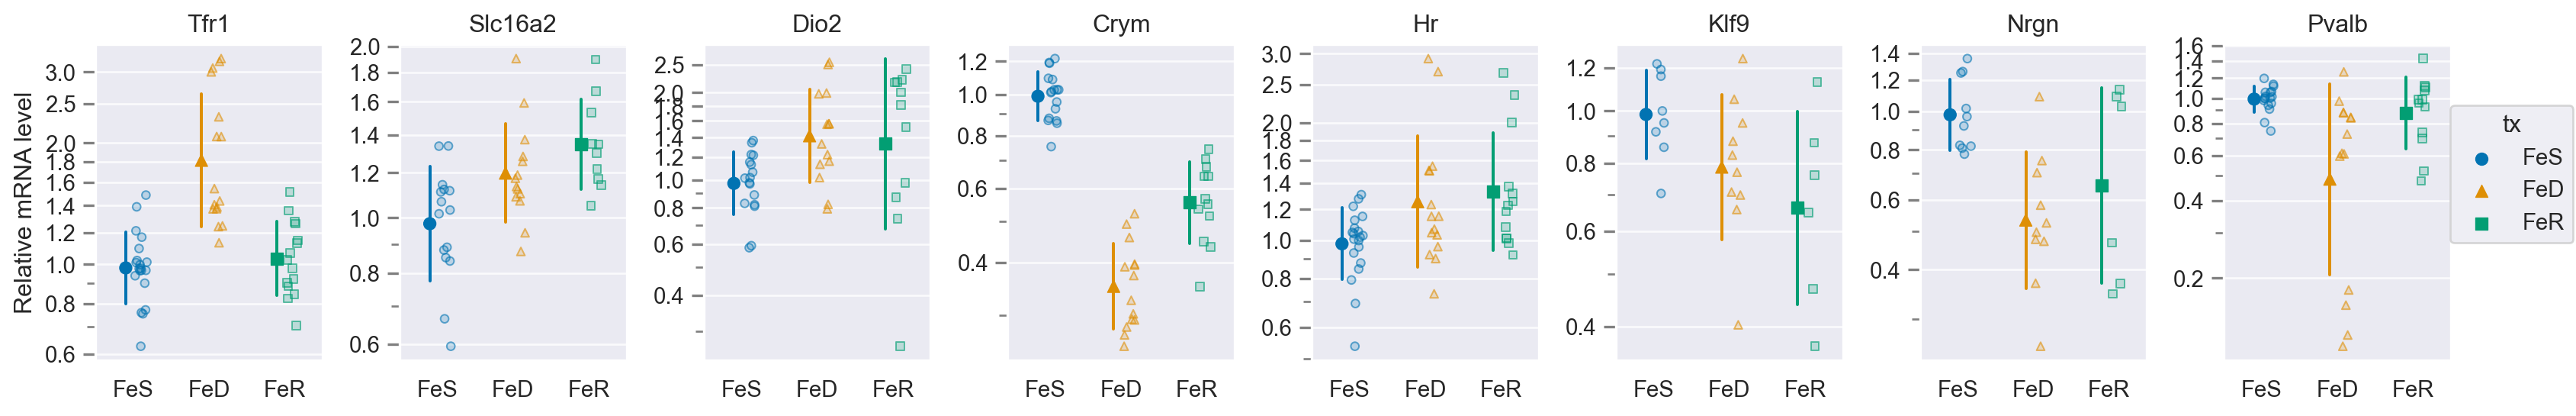

In [15]:
univariate_plot(
    folder_name='qPCR_univariate_fun',
    file_name='21DIV.svg',
    tick_list=[0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3],
    plot_data=indexing(
        data=data.dropna(),
        div=['21'],
    ).reset_index(),
    x_label='',
    y_label='Relative mRNA level',
    y_share=False,
    facet_col='gene',
    layout_size=(17, 3)
)


# PCA to determine variables which explain variability in the dataset
Some resources for PCA analysis, plotting, etc 
* https://www.jcchouinard.com/pca-with-python/
* https://www.reneshbedre.com/blog/principal-component-analysis.html
* https://www.reneshbedre.com/blog/principal-component-analysis.html#principal-component-pc-retention
### PCA interpretation 
* **The first three PCs (3D) contribute ~81% of the total variation in the dataset and have eigenvalues > 1, and thus provides a good approximation of the variation present in the original 6D dataset** (see the cumulative proportion of variance and scree plot). The cut-off of cumulative 70% variation is common to retain the PCs for analysis (Jolliffe et al., 2016). Even though the first four PCs contribute ~99% and have eigenvalues > 1, it will be difficult to visualize them at once and needs to perform pairwise visualization.

* From the biplot and loadings plot, we can see the variables D and E are highly associated and forms cluster (gene expression response in D and E conditions are highly similar). Similarly, A and B are highly associated and forms another cluster (gene expression response in A and B conditions are highly similar but different from other clusters). If the variables are highly associated, the angle between the variable vectors should be as small as possible in the biplot.

* **The length of PCs in biplot refers to the amount of variance contributed by the PCs. The longer the length of PC, the higher the variance contributed and well represented in space.**

In [40]:
# The grand function
def pca_results(
    data=indexing(
        data=data.apply(np.log10),
        div=['11']
    )
):
    pca_data = data
    # impute median of long data, this is cleaner than wide data and does not require iterator
    imp_data = pca_data.fillna(
        pca_data.groupby(['tx', 'gene']).transform('median')
    )
    pca_wide_data = (
        imp_data
        .reset_index()
        .pivot(
            columns='gene',
            index=['div', 'tx', 'sample'],
            values='mrna'
        )
    )

    # PCA
    pca = PCA(n_components=None)
    # because call only values and have index, then only column values are kept and not index values, which is what we want
    pca_result = pca.fit_transform(pca_wide_data.values)

    print('Explained variation per principal component: {}'.format(
        pca.explained_variance_ratio_))

    pca_result_data = pca_wide_data.copy()
    pca_result_data['PC1'] = pca_result[:, 0]
    pca_result_data['PC2'] = pca_result[:, 1]

    # Loadings
    # Data must be transformed (.T) beecause pca.components_ columns represent each variable and each row represents a PC. This can be confirmed by looking at the shape when the PCA is set to less than the maximum number of components
    loadings_df = pd.DataFrame(
        data=pca.components_.T,
        columns=['PC'+str(i) for i in list(range(1, pca.n_components_+1))],
        index=pca_wide_data.columns.values
    ).rename_axis('gene')

    return pca, pca_result_data, loadings_df


In [41]:
def pca_biplot(
    loadings_df=None,
    pca=None,
    pca_result_data=None,
    folder_name='PCA_test',
    file_name='PCA_test_biplot.svg',
    size=(4.5, 3.5)
):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    save_loc = pathlib.Path(folder_name + '/' + file_name)

    # Loading Vectors for Biplot
    loadings_origin = loadings_df.copy()
    loadings_origin['PC1'] = 0
    loadings_origin['PC2'] = 0

    loadings_paths = pd.concat([loadings_df, loadings_origin])
    loadings_paths

    # Dot plot of PCAs
    dot_plot = (
        so.Plot(
            data=pca_result_data,
            x='PC1',
            y='PC2',
            color='tx',
            marker='tx',
        )
        .add(so.Dots(pointsize=10))
        .scale(
            color='colorblind',
            marker=so.Nominal(['o', '^', 's']),
        )
    )
    # Loadings Vectors
    loading_vectors = (
        so.Plot(
            data=loadings_paths.reset_index(),
            x='PC1',
            y='PC2',
            group='gene',
        )
        .add(so.Path(color='#9a5b8eff'))
    )
    # Loadings Labels
    loading_labels = (
        so.Plot(
            data=loadings_df,
            x='PC1',
            y='PC2',
            text='gene'
        )
        .add(so.Text({'style': 'italic'}, valign='bottom', color='black'))
        .label(
            x=('PC1 (' +
                str(round(pca.explained_variance_ratio_[0]*100, 2)) + '%)'),
            y=('PC2 (' +
                str(round(pca.explained_variance_ratio_[1]*100, 2)) + '%)'),
        )
        .theme({
               'ytick.left': True,
               'ytick.color': '.5',
               'ytick.labelcolor': '.15',
               'axes.grid': True,
               'grid.alpha': 0.8,
               })
    )

    fig, ax = plt.subplots(figsize=size)
    dot_plot.on(ax).plot()
    loading_vectors.on(ax).plot()
    loading_labels.on(ax).plot().save(save_loc, bbox_inches='tight')
    return ax


In [42]:
def pca_loadingmap(
    loadings_df=None,
    folder_name='PCA_test',
    file_name='PCA_test_loadingmap.svg',
):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    save_loc = pathlib.Path(folder_name + '/' + file_name)

    # correlation matrix plot for loadings
    sns.heatmap(data=loadings_df,
                annot=True,
                fmt='.2f',
                cmap='vlag',
                center=0,
                )
    plt.savefig(fname=save_loc, bbox_inches='tight')


In [43]:
def pca_screeplot(
    pca=None,
    folder_name='PCA_test',
    file_name='PCA_test_screeplot.svg',
):
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    save_loc = pathlib.Path(folder_name + '/' + file_name)

    # Scree Plot
    scree_data = pd.DataFrame(
        {'explained_variance_ratio': pca.explained_variance_ratio_,
         'PC': [str(i) for i in list(range(1, pca.n_components_+1))]}
    )

    p = (
        so.Plot(
            data=scree_data,
            x='PC',
            y='explained_variance_ratio',
        )
        .add(so.Bar())
        .add(so.Line())
        .label(
            y='Explained Variance Ratio',
            x='Principal Component'
        )
        .theme({
            'ytick.left': True,
            'ytick.color': '.5',
            'ytick.labelcolor': '.15',
            'axes.grid': True,
            'grid.alpha': 0.8,
        })
        .layout(size=(3, 3))
        .save(loc=save_loc, bbox_inches='tight')
    )
    return p


## 11 DIV

In [44]:
pca, pca_result_data, loadings_df = pca_results(
    data=indexing(
        data=data.apply(np.log10),
        div=['11']
    )
)


Explained variation per principal component: [0.42611765 0.27244248 0.14385832 0.06320679 0.03447389 0.02694024
 0.01880742 0.01071795 0.00343526]


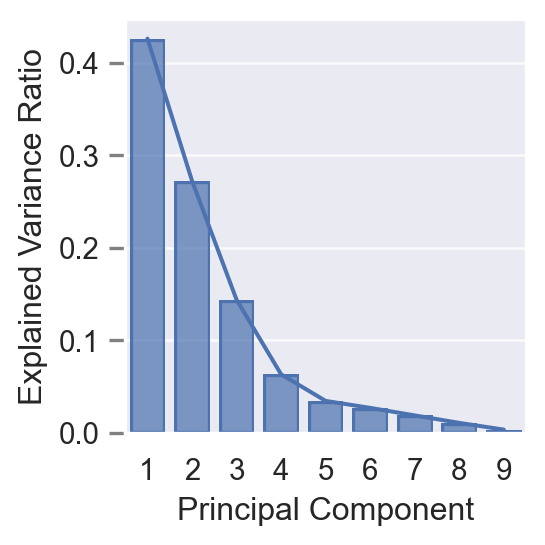

In [25]:
pca_screeplot(
    pca=pca,
    folder_name='PCA_plots_new',
    file_name='11DIV-screeplot.svg'
)


<AxesSubplot: xlabel='PC1 (42.61%)', ylabel='PC2 (27.24%)'>

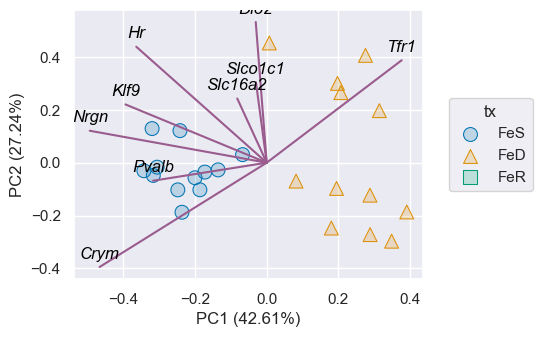

In [40]:
pca_biplot(
    loadings_df=loadings_df,
    pca=pca,
    pca_result_data=pca_result_data,
    folder_name='PCA_plots_new',
    file_name='11DIV-biplot.svg'
)


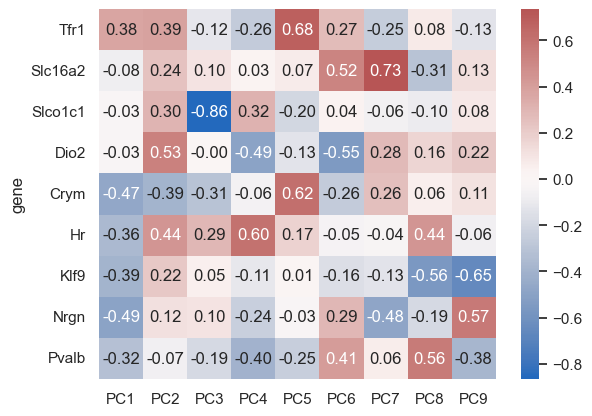

In [45]:
pca_loadingmap(
    loadings_df=loadings_df,
    folder_name='PCA_plots_new',
    file_name='11DIV-loadingmap.svg'
)


## 18 DIV

In [26]:
pca, pca_result_data, loadings_df = pca_results(
    data=indexing(
        data=data.apply(np.log10),
        div=['18']
    )
)


Explained variation per principal component: [0.64546299 0.17999382 0.09988971 0.02422928 0.0169773  0.01403284
 0.01012952 0.00641488 0.00286966]


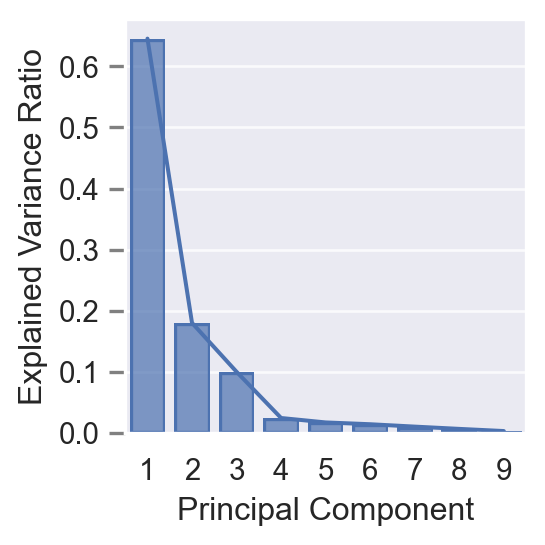

In [27]:
pca_screeplot(
    pca=pca,
    folder_name='PCA_plots_new',
    file_name='18DIV-screeplot.svg'
)


<AxesSubplot: xlabel='PC1 (64.55%)', ylabel='PC2 (18.0%)'>

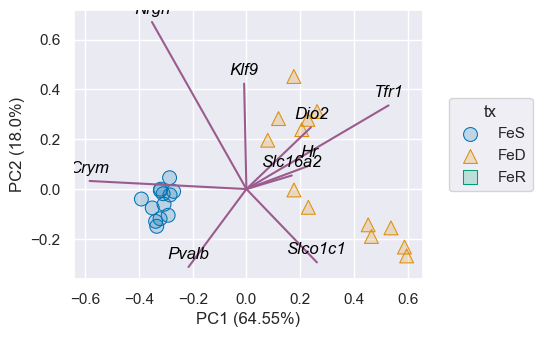

In [58]:
pca_biplot(
    loadings_df=loadings_df,
    pca=pca,
    pca_result_data=pca_result_data,
    folder_name='PCA_plots_new',
    file_name='18DIV-biplot.svg'
)


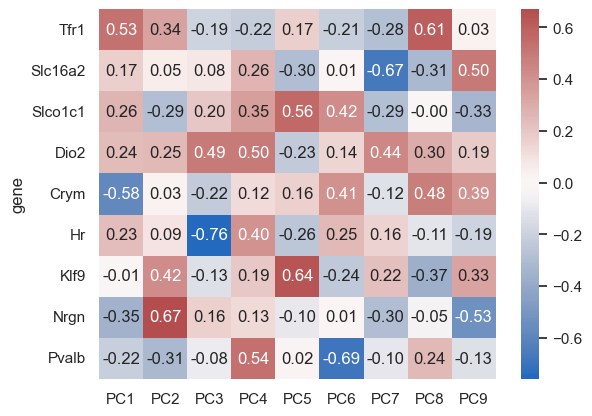

In [59]:
pca_loadingmap(
    loadings_df=loadings_df,
    folder_name='PCA_plots_new',
    file_name='18DIV-loadingmap.svg'
)


## 21 DIV

In [60]:
# # Need to figure out how to drop Slco1c1, basically, select all columns but a certain index
# div_data = indexing(
#     data=data.apply(np.log10),
#     div=['21'],
#     gene=['Tfr1','Slc16a2','Dio2','Hr','Crym','Klf9','Nrgn','Pvalb']
# )
# div_data
# pca_data = div_data
# imp_data = pca_data.fillna(
#     pca_data.groupby(['tx', 'gene']).transform('median')
# )
# pca_wide_data = (
#     imp_data
#     .reset_index()
#     .pivot(
#         columns='gene',
#         index=['div','tx','sample'],
#         values='mrna'
#     )
# )

# pca_wide_data

# # PCA
# pca = PCA(n_components=None)
# # because call only values and have index, then only column values are kept and not index values, which is what we want
# pca_result = pca.fit_transform(pca_wide_data.values)

# print('Explained variation per principal component: {}'.format(
#     pca.explained_variance_ratio_))


In [28]:
pca, pca_result_data, loadings_df = pca_results(
    data=indexing(
        data=data.apply(np.log10),
        div=['21'],
        gene=['Tfr1', 'Slc16a2', 'Dio2', 'Hr', 'Crym', 'Klf9', 'Nrgn', 'Pvalb']
    )
)


Explained variation per principal component: [0.48463566 0.22813188 0.11886381 0.07690073 0.0356619  0.02911891
 0.01735532 0.0093318 ]


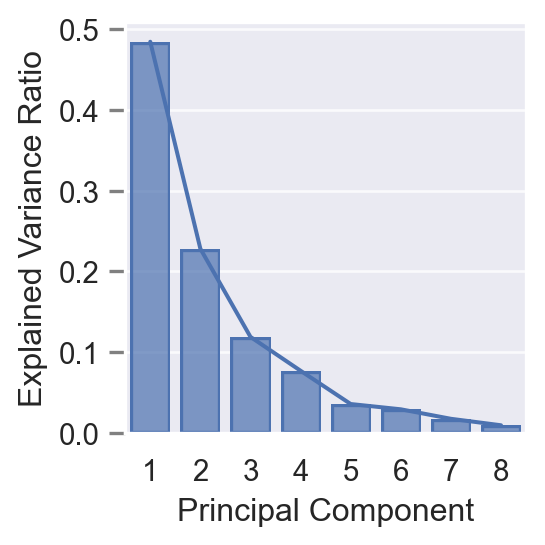

In [29]:
pca_screeplot(
    pca=pca,
    folder_name='PCA_plots_new',
    file_name='21DIV-screeplot.svg'
)


<AxesSubplot: xlabel='PC1 (48.46%)', ylabel='PC2 (22.81%)'>

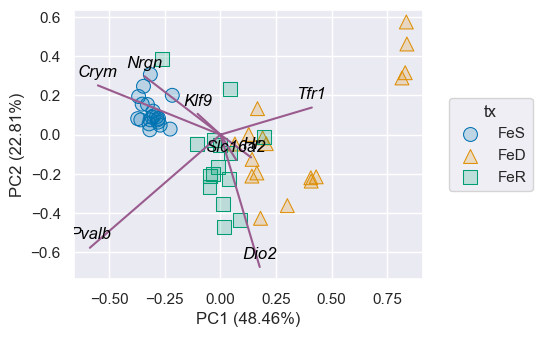

In [63]:
pca_biplot(
    loadings_df=loadings_df,
    pca=pca,
    pca_result_data=pca_result_data,
    folder_name='PCA_plots_new',
    file_name='21DIV-biplot.svg'
)


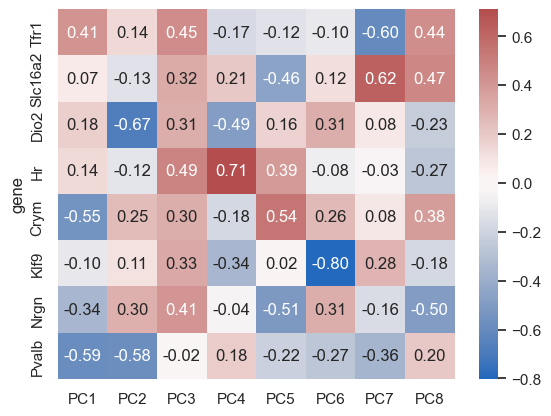

In [64]:
pca_loadingmap(
    loadings_df=loadings_df,
    folder_name='PCA_plots_new',
    file_name='21DIV-loadingmap.svg'
)
